In [358]:
import pandas as pd
import numpy as np
import math
from sklearn.impute import SimpleImputer
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mord import LogisticIT
import warnings 
import copy 
warnings.simplefilter('ignore')

SEED = 777

## Load Data

In [356]:
col_names = ['income','sex','married','age','education','occupation',
             'time_in_area','dual_income','num_people_household',
             'num_children_household','home_status','home_type','ethnicity',
             'language']
df = pd.read_csv('marketing.data', delimiter=" ",header=None, names=col_names)

df.head()

,income,sex,married,age,education,occupation,time_in_area,dual_income,num_people_household,num_children_household,home_status,home_type,ethnicity,language
0,9,2,1.0,5,4.0,5.0,5.0,3,3.0,0,1.0,1.0,7.0,NaN
1,9,1,1.0,5,5.0,5.0,5.0,3,5.0,2,1.0,1.0,7.0,1.0
2,9,2,1.0,3,5.0,1.0,5.0,2,3.0,1,2.0,3.0,7.0,1.0
3,1,2,5.0,1,2.0,6.0,5.0,1,4.0,2,3.0,1.0,7.0,1.0
4,1,2,5.0,1,2.0,6.0,3.0,1,4.0,2,3.0,1.0,7.0,1.0


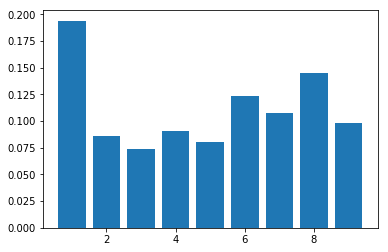

Baseline Accuracy: 0.19403980874013121


In [357]:
Y = np.array(df['income'])
X = np.array(df.drop('income',axis=1))

plt.bar(pd.value_counts(Y).index,pd.value_counts(Y).values/len(Y))
plt.show()

print(f"Baseline Accuracy: {pd.value_counts(Y).values[0]/len(Y)}")

Split the data 80-20 into a train and a test set using stratified random sampling to preserve the proportion of classes in the response variable

In [359]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=.2, stratify = Y, random_state = SEED)

### Define a KNN Imputer
Define a class to impute missing values in each feature using K-Nearest-Neighbors Classifier trained to predict the non-missing values using the other features. Feature classifiers are only fit on the training data in each step and do not see the test or validation data during training. This is to prevent data leakage.

In [360]:
class KNNImputer():
    def __init__(self):
        # Try an array of n values for each classifier
        self.model = GridSearchCV(KNeighborsClassifier(),{'n_neighbors':[5,10,15,20]}, cv=3, n_jobs=-1)
        self.model_list = [None]
        self.X = np.array([])
        
    def fit(self, X, verbose = 0):
        # create deep copy to avoid altering the original data
        self.X = copy.deepcopy(X)

        if len(self.X.shape)==1 or self.X.shape[1]==0:
            self.X = self.X.reshape(-1,1)

        self.model_list = [None]*(self.X.shape[1])
        
        # count of missing values per column
        col_nan_count = np.sum(np.isnan(self.X),axis=0)
    
        # Indexes of columns with at least 1 missing value sorted from most to least missing values
        col_nan_count_sorted = sorted(enumerate(col_nan_count),key=lambda x: x[1], reverse=True)
        col_ix_sorted = [tup[0] for tup in col_nan_count_sorted if tup[1]>0]

        tot_nan = sum(np.sum(np.isnan(self.X),axis=0))
        
        # for each column with missing values, sorted from most missing values to least..
        for i in col_ix_sorted:
            target = self.X[:,i].reshape(-1,1) # feature to fill missing values for
            features = np.delete(self.X, i, axis=1) # features used to predict missing values
            
            # scale features so that each has equal sway in KNN classification
            scaler = StandardScaler()
            features = scaler.fit_transform(features)
            
            # seperate missing values (to be predicted) and existing values (used to train classifier)
            target_train = target[[not na for na in np.isnan(target)]]
            target_missing = target[np.isnan(target)]
            
            # isolate observations with corresponding target values for training
            features_train = features[[not na for na in np.isnan(target).flatten()]]
            # temporarily fill in missing values in observation features used to train imputer
            mean_imputer = SimpleImputer(strategy='most_frequent')
            features_train = mean_imputer.fit_transform(features_train)
            
            # isolate feature observations with no corresponding target feature for prediction
            features_missing = features[np.isnan(target).flatten()]
            features_missing = mean_imputer.fit_transform(features_missing)
            
            # train model and store it in mode list corresponding to feature index
            self.model_list[i] = self.model.fit(features_train, target_train)

            in_sample_acc = self.model_list[i].score(features_train, target_train)
            #if False:
            #    print(f"Column {i} - filled {col_nan_count[i]} NaN values - in sample accuracy: {in_sample_acc}")
            
            # predict in missing values
            predictions_missing = self.model.predict(features_missing)
            # fill missing values in with predictions
            target[np.isnan(target)] = predictions_missing
            self.X[:,i] = target.flatten()
        
        # for each column without missing values  
        non_na_col_ix = set(range(0,self.X.shape[1])).difference(col_ix_sorted)
        #train model to predict the column features using other features. No missing values to fill in.
        for i in non_na_col_ix:
            target = self.X[:,i].reshape(-1,1)
            features = np.delete(self.X, i, axis=1)
            
            self.model_list[i] = self.model.fit(features, target)
            
    def fit_transform(self, X, verbose = 0):
        X_backup = copy.deepcopy(X)
    
        self.fit(X, verbose = verbose)
        assert sum(sum(np.isnan(X))) == sum(sum(np.isnan(X_backup)))
        return self.X

    def transform(self, X):
        self.X = copy.deepcopy(X)
        col_nan_count = np.sum(np.isnan(X),axis=0)
        col_ixs = [i for i, count in enumerate(col_nan_count) if count>0]

        for i in col_ixs:
            target = self.X[:,i].reshape(-1,1)
            features = np.delete(self.X, i, axis=1)
            features_missing = features[np.isnan(target).flatten()]
            if len(features_missing.shape)==1:
                features_missing = features_missing.reshape(-1,1)
            features_missing = mean_imputer.fit_transform(features_missing)

            predictions_missing = self.model_list[i].predict(features_missing)

            target[np.isnan(target)] = predictions_missing
            
            # Replace features 
            self.X[:,i] = target.flatten()

        return self.X

### Preprocessing

In [321]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

def col_ix(label):
    col_list = ['sex','married','age','education','occupation',
                'time_in_area','dual_income','num_people_household',
                'num_children_household','home_status','home_type','ethnicity',
                'language']

    return col_list.index(label)

# Artificial predictor to satisfy Pipeline's requirement that the last class needs to be an estimator 
# (able to take a Y parameter)
class LastEstimator():
    def __init__(self):
        self.encoder=None
    def fit(self,X,Y=None):
        return self
    def transform(self, X, Y=None):
        return X
    def fit_transform(self, X, Y=None):
        #print("LastEstimator.fit_transform")
        return X

# Class to convert 0 dimensional NP arrays to 1 dimensional NP arrays for compatibility 
class reshaper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.x = 0

    def fit(self, X=None, Y=None):
        return self

    def transform(self, X, Y=None):
        if type(X) is pd.Series:
            X=X.values
        return X.reshape(-1, 1)

# Class to convert sparse scipy arrays NP arrays for compatibility 
class ToDenseArray():
    def __init__(self):
        None
    def fit(self, X, Y=None):
        return self
    def transform(self, X, Y=None):
        return X.toarray()

# Define pipeline to preprocess numeric features:
    # age, time_in_area, num_people_household, num_child_household
numeric_pipeline = Pipeline([
    ('reshape', reshaper()),
    ('scale', MinMaxScaler()),
    ('deskew',PowerTransformer()),
    ('predict',LastEstimator())
    ]) # scale and deskew each numeric feature

# Define pipeline to preprocess binary features:
    # sex, married
binary_pipeline = Pipeline([
    ('reshape', reshaper()),
    ('OHE', OneHotEncoder(handle_unknown='ignore')),
    ('to_dense',ToDenseArray()),
    ('predict',LastEstimator())
]) # # Make dummy variables for both possible values of each binary feature

# Define pipeline to preprocess numeric features:
    # dual_income, education, occupation, home_status, home_type, ethnicity, language
categorical_pipeline = Pipeline([
    ('reshape', reshaper()),
    ('OHE', OneHotEncoder(handle_unknown='ignore')),
    ('to_dense',ToDenseArray()),
    ('predict',LastEstimator())
]) # Make dummy variables for each possible value of each categorical feature

# define columnransformer to apply preprocessing steps to each feature
ct = ColumnTransformer([
    ('sex', binary_pipeline, col_ix('sex')),
    ('married', binary_pipeline, col_ix('married')),
    ('dual_income', categorical_pipeline, col_ix('dual_income')),
    ('education', categorical_pipeline, col_ix('education')),
    ('occupation', categorical_pipeline, col_ix('occupation')),
    ('home_status', categorical_pipeline, col_ix('home_status')),
    ('home_type', categorical_pipeline, col_ix('home_type')),
    ('ethnicicty', categorical_pipeline, col_ix('ethnicity')),
    ('language', categorical_pipeline, col_ix('language')),
    ('age', numeric_pipeline, col_ix('age')),
    ('time_in_area', numeric_pipeline, col_ix('time_in_area')),
    ('num_people_household', numeric_pipeline, col_ix('num_people_household')),
    ('num_children_household', numeric_pipeline, col_ix('num_children_household')),  
    ])

In [418]:
def report_metrics(pipeline_gridsearch):
    estimator = pipeline_gridsearch.best_estimator_
    
    best_params = estimator.named_steps['clf'].best_params_
    best_score_cv = pipeline_gridsearch.best_score_
    score_std = pipeline_gridsearch.cv_results_['std_test_score'][pipeline_gridsearch.best_index_]
    train_score = accuracy_score(estimator.predict(x_train), y_train)
    test_score = accuracy_score(estimator.predict(x_test), y_test)
    
    estimator.fit(x_train, y_train)
    test_score_refit = accuracy_score(estimator.predict(x_test), y_test)

    print('{:<40}: {:<50}'.format('Best parameters', repr(best_params)))
    print('{:<40}: {:<50}'.format('Best validation score', '{} +-{}'.format(round(best_score_cv,3),round(score_std,3))))
    print('{:<40}: {:<50}'.format('Train score', round(train_score,3)))
    print('{:<40}: {:<50}'.format('Test score', round(test_score,3)))
    print('{:<40}: {:<50}'.format('Test score (all training data)', test_score_refit))

# Classification

### 1. K-Nearest-Neighbors Classifier

In [402]:
# Try odd values between 5 and 29 for N
KNN_param_grid = {
    'n_neighbors': [x*2+1 for x in range(2,14)]
}

KNN_gridsearch = GridSearchCV(KNeighborsClassifier(), KNN_param_grid, cv=3, n_jobs=-1)

KNN_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', KNN_gridsearch)
    ])

KNN_pipeline_gridsearch = GridSearchCV(KNN_pipeline, param_grid={}, cv=3, n_jobs=-1)

KNN_pipeline_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x00000253985BEE48>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [419]:
print("{:^60}".format("KNN CLASSIFIER RESULTS"))
report_metrics(KNN_pipeline_gridsearch)

                   KNN CLASSIFIER RESULTS                   
Best parameters                         : {'n_neighbors': 23}                               
Best validation score                   : 0.324 +-0.007                                     
Train score                             : 0.394                                             
Test score                              : 0.326                                             
Test score (all training data)          : 0.3257365202890495                                


### 2a. Logistic Regression - No Regularization

In [404]:
LR_param_grid = {
}

LR_gridsearch = GridSearchCV(LogisticRegression(), LR_param_grid, cv=3, n_jobs=-1)

LR_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', LR_gridsearch)
    ])

LR_pipeline_gridsearch = GridSearchCV(LR_pipeline, param_grid={}, cv=3, n_jobs=-1)
LR_pipeline_gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x00000253AB28A9E8>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [420]:
print("{:^60}".format("LOGISTIC REGRESSION RESULTS"))
report_metrics(LR_pipeline_gridsearch)

                LOGISTIC REGRESSION RESULTS                 
Best parameters                         : {}                                                
Best validation score                   : 0.334 +-0.004                                     
Train score                             : 0.362                                             
Test score                              : 0.342                                             
Test score (all training data)          : 0.3424124513618677                                


### 2b. Logistic Regression -  L1 Regularization

In [406]:
LR1_param_grid = {
    'penalty': ['l1'],
    'C':[12,11,10,9,8,7,6]
}

LR1_gridsearch = GridSearchCV(LogisticRegression(), LR1_param_grid, cv=3, n_jobs=-1)

LR1_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', LR1_gridsearch)
    ])

LR1_pipeline_gridsearch = GridSearchCV(LR1_pipeline, param_grid={}, cv=3, n_jobs=-1)
LR1_pipeline_gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x00000253AB3534E0>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [421]:
print("{:^60}".format("LOGISTIC REGRESSION (L1 PENALTY) RESULTS"))
report_metrics(LR1_pipeline_gridsearch)

          LOGISTIC REGRESSION (L1 PENALTY) RESULTS          
Best parameters                         : {'C': 9, 'penalty': 'l1'}                         
Best validation score                   : 0.334 +-0.004                                     
Train score                             : 0.363                                             
Test score                              : 0.34                                              
Test score (all training data)          : 0.33852140077821014                               


### 2c. Logistic Regression - L2 Regularization

In [410]:
LR2_param_grid = {
    'penalty': ['l2'],
    'C':[10, 8, 6, 5, 4, 2]
}

LR2_gridsearch = GridSearchCV(LogisticRegression(), LR2_param_grid, cv=3, n_jobs=-1)

LR2_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', LR1_gridsearch)
    ])

LR2_pipeline_gridsearch = GridSearchCV(LR2_pipeline, param_grid={}, cv=3, n_jobs=-1)
LR2_pipeline_gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x0000025397D746D8>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [422]:
print("{:^60}".format("LOGISTIC REGRESSION (L2 PENALTY) RESULTS"))
report_metrics(LR2_pipeline_gridsearch)

          LOGISTIC REGRESSION (L2 PENALTY) RESULTS          
Best parameters                         : {'C': 11, 'penalty': 'l1'}                        
Best validation score                   : 0.335 +-0.004                                     
Train score                             : 0.363                                             
Test score                              : 0.337                                             
Test score (all training data)          : 0.33740967204002226                               


### 3. LogisticIT

In [416]:
LRIT_param_grid = {
    'alpha':[0.05,0.075,0.1,0.2,0.3,0.4]
}

LRIT_gridsearch = GridSearchCV(LogisticIT(), LRIT_param_grid, cv=3, n_jobs=-1)

LRIT_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', LRIT_gridsearch)
    ])

LRIT_pipeline_gridsearch = GridSearchCV(LRIT_pipeline, param_grid={}, cv=3, n_jobs=-1)
LRIT_pipeline_gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x00000253AB364400>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [423]:
print("{:^60}".format("ORDINAL LOGISTIC (IMMEDIATE THRESHOLD) RESULTS"))
report_metrics(LRIT_pipeline_gridsearch)

       ORDINAL LOGISTIC (IMMEDIATE THRESHOLD) RESULTS       
Best parameters                         : {'alpha': 0.05}                                   
Best validation score                   : 0.325 +-0.006                                     
Train score                             : 0.327                                             
Test score                              : 0.32                                              
Test score (all training data)          : 0.32017787659811003                               


### 4. Random Forest Classifier

In [414]:
RF_param_grid = {
    'n_estimators': [x*100 for x in range(1,10)]
}

RF_gridsearch = GridSearchCV(RandomForestClassifier(), RF_param_grid, cv=3, n_jobs=-1)

RF_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', RF_gridsearch)
    ])

RF_pipeline_gridsearch = GridSearchCV(RF_pipeline, param_grid={}, cv=3, n_jobs=-1)
RF_pipeline_gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x00000253CA6D8320>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [424]:
print("{:^60}".format("RANDOM FOREST RESULTS"))
report_metrics(RF_pipeline_gridsearch)

                   RANDOM FOREST RESULTS                    
Best parameters                         : {'n_estimators': 200}                             
Best validation score                   : 0.317 +-0.008                                     
Train score                             : 0.87                                              
Test score                              : 0.31                                              
Test score (all training data)          : 0.31017231795441913                               


In [428]:
from xgboost.sklearn import XGBClassifier

XGBC1_param_grid = {
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[5],
    'min_child_weight':[1],
    'gamma':[0],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'scale_pos_weight':[1],
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
}

XGBC1_gridsearch = GridSearchCV(XGBClassifier(), XGBC1_param_grid, cv=3, n_jobs=-1)

XGBC1_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('preprocess', ct),
    ('clf', XGBC1_gridsearch)
    ])

XGBC1_pipeline_gridsearch = GridSearchCV(XGBC1_pipeline, param_grid={}, cv=3, n_jobs=-1)
XGBC1_pipeline_gridsearch.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', <__main__.KNNImputer object at 0x0000025397D7B470>), ('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('reshape', reshaper()), ('OHE', OneHotEnco...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [429]:
print("{:^60}".format("BOOSTED FOREST CLASSIFIER #1 RESULTS"))
report_metrics(XGBC1_pipeline_gridsearch)

            BOOSTED FOREST CLASSIFIER #1 RESULTS            
Best parameters                         : {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 1000, 'scale_pos_weight': 1, 'subsample': 0.8}
Best validation score                   : 0.329 +-0.007                                     
Train score                             : 0.557                                             
Test score                              : 0.338                                             
Test score (all training data)          : 0.3379655364091162                                
